Creating DataHandler, Strategy, Portfolio and ExecutionHandler
Creating equity curve...
             600050  600233      cash  commission     total  equity_returns  equity_curve
datetime                                                                                 
2017-03-20  77700.0     0.0  285090.0         0.0  362790.0        0.000000        3.6279
2017-03-21  76600.0     0.0  285090.0         0.0  361690.0       -0.003032        3.6169
2017-03-22  76600.0     0.0  285090.0         0.0  361690.0        0.000000        3.6169
2017-03-23  77900.0     0.0  285090.0         0.0  362990.0        0.003594        3.6299
2017-03-24  76600.0     0.0  285090.0         0.0  361690.0       -0.003581        3.6169
2017-03-27  75300.0     0.0  285090.0         0.0  360390.0       -0.003594        3.6039
2017-03-28  74400.0     0.0  285090.0         0.0  359490.0       -0.002497        3.5949
2017-03-29  74300.0     0.0  285090.0         0.0  359390.0       -0.000278        3.5939
2017-03-30  

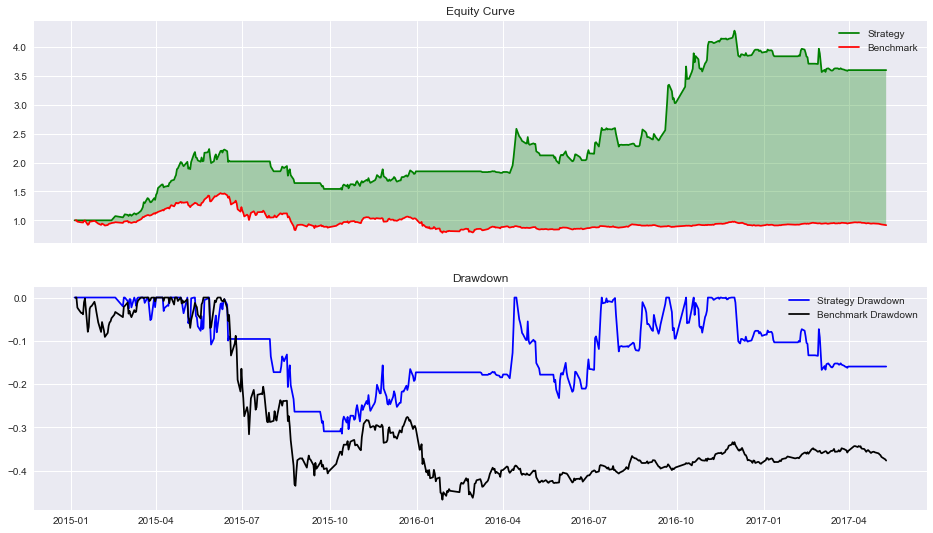

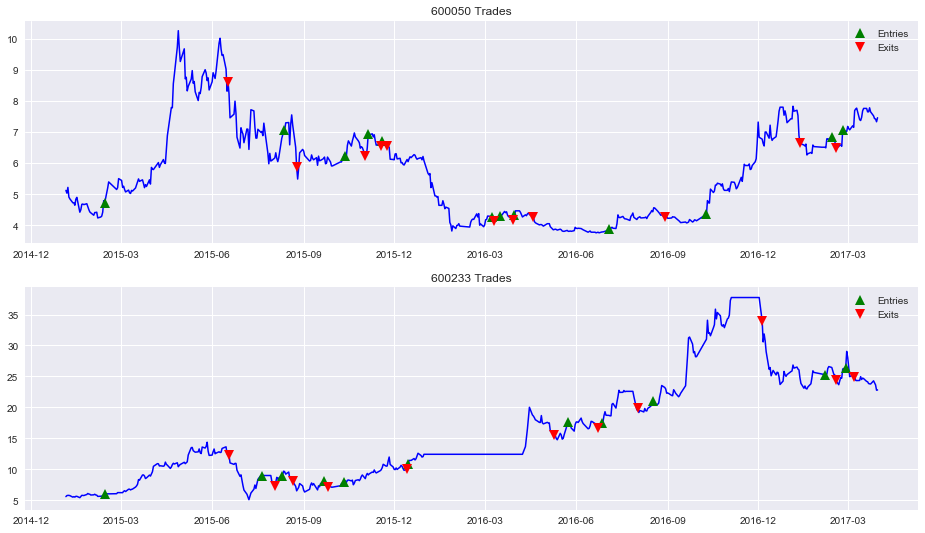

In [1]:
# %load StEMA.py
"""
Created on Sat May 19 14:20:16 2018

@author: mai1346
"""
import datetime
import talib
import pandas as pd
pd.set_option('expand_frame_repr', False)
%matplotlib inline

from Backtest import Backtest
from Data import HistoricSQLDataHandler,TushareDataHandler
from Event import SignalEvent
from Execution import SimulatedExecutionHandler
from Portfolio import Portfolio
from Strategy import Strategy
from RiskManager import Naive_Riskmanager

class EMACrossStrategy(Strategy):

    def __init__(self, data_handler, events, short_window = 5, long_window = 20):
        self.data_handler = data_handler
        self.symbol_list = self.data_handler.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window
        self.sema = {symbol: [] for symbol in self.symbol_list}
        self.lema = {symbol: [] for symbol in self.symbol_list}
        # Set to True if a symbol is in the market
        self.bought = self._initialize_bought()

    def _initialize_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought

    def generate_signal(self, event):

        if event.type == 'MARKET':

            for symbol in self.symbol_list:
                bars = self.data_handler.get_latest_bars_values(symbol, "close", N = 0)
                if bars is not None:
                    
                    sema = talib.EMA(bars, self.short_window)[-1]
                    self.sema[symbol].append(sema)
                    lema = talib.EMA(bars, self.long_window)[-1]
                    self.lema[symbol].append(lema)

                    dt = self.data_handler.get_latest_bar_datetime(symbol)

                    if len(self.sema[symbol]) > 1 and self.sema[symbol][-2] != None:
                        if sema > lema and self.sema[symbol][-2] < self.lema[symbol][-2] and self.bought[symbol] == "OUT":
                            signal = SignalEvent(symbol, dt, 'LONG')
                            self.events.put(signal)
                            self.bought[symbol] = 'LONG'
                        elif sema < lema and self.sema[symbol][-2] > self.lema[symbol][-2] and self.bought[symbol] == "LONG":
                            signal = SignalEvent( symbol, dt, 'EXIT')
                            self.events.put(signal)
                            self.bought[symbol] = 'OUT'

if __name__ == "__main__":
    symbol_list = ['600050','600233']
    initial_capital = 100000.0
    start_date = datetime.datetime(2015,1,1,0,0,0)
    end_date = datetime.datetime(2017,5,10,0,0,0)
    heartbeat = 0.0
    benchmark = 'hs300'

    backtest = Backtest(symbol_list,
                        initial_capital,
                        heartbeat,
                        start_date,
                        end_date,
                        TushareDataHandler,
                        SimulatedExecutionHandler,
                        Portfolio,
                        Naive_Riskmanager,
                        EMACrossStrategy,
                        benchmark)

    backtest.simulate_trading()
